In [1]:
# %tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
import numpy as np
import pandas as pd
from keras.layers import Input, Dense, Activation, Flatten, Conv2D, Lambda, MaxPooling2D, Dropout
from keras.utils import print_summary
from keras import models
from keras import layers
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.applications import VGG16
from keras_preprocessing.image import ImageDataGenerator
from scipy import pi


2.1.0


Using TensorFlow backend.


In [2]:
trainDF = pd.read_csv('/home/jupyter/Project/train.txt', sep=" ", header=None)
trainDF.columns = ['Images', 'SteeringAngle'] 
trainDF['SteeringAngle'] = trainDF['SteeringAngle'] * (pi / 180)

testDF = pd.read_csv('/home/jupyter/Project/test.txt', sep=" ", header=None)
testDF.columns = ['Images', 'SteeringAngle'] 

datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            validation_split=0.25)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator=datagen.flow_from_dataframe(
dataframe=trainDF,
directory="/home/jupyter/Project/train/",
x_col="Images",
y_col="SteeringAngle",
subset="training",
batch_size=100,
seed=42,
shuffle=False,
class_mode="raw",
target_size=(200,66))

validation_generator = datagen.flow_from_dataframe(
dataframe=trainDF,
directory="/home/jupyter/Project/train/",
x_col="Images",
y_col="SteeringAngle",
subset="validation",
batch_size=100,
seed=42,
shuffle=False,
class_mode="raw",
target_size=(200,66))


Found 27342 validated image filenames.
Found 9113 validated image filenames.


In [4]:
def VGG_FT_PartA(width, height, depth):

    conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(height, width, depth))

    model = models.Sequential()
    model.add(conv_base)
    conv_base.trainable = False
    model.add(layers.Flatten())

    model.add(Dense(1164, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='relu'))    
    model.add(Dense(1, activation='linear'))

    return model


In [6]:
NUM_EPOCHS = 30

model = VGG_FT_PartA(width=66, height=200, depth=3)

filepath = "/home/jupyter/Project/VGG/VGG_FE_Chekpoints/VGG_FE_weights.01-0.00.h5"

model.load_weights(filepath)

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(200, 66, 3))

conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model.compile(optimizer=Adam(lr=1e-5), loss="mse")

filepath = "/home/jupyter/Project/VGG/VGG_FT_Chekpoints/VGG_FT_weights.{epoch:02d}-{val_loss:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor="val_loss", mode="min", save_best_only=True, verbose=1)

history = model.fit(
                train_generator,
                steps_per_epoch=329,
                epochs=NUM_EPOCHS,
                validation_data=validation_generator,
                validation_steps=37,
                callbacks=[checkpoint])

model.save_weights(filepath)

Epoch 1/30
329/329 [==============================] - 248s 753ms/step - loss: 0.2085 - val_loss: 0.0027

Epoch 00001: val_loss improved from inf to 0.00266, saving model to /home/jupyter/Project/VGG/VGG_FT_Chekpoints/VGG_FT_weights.01-0.00.h5
Epoch 2/30
329/329 [==============================] - 237s 720ms/step - loss: 0.2247 - val_loss: 0.0047

Epoch 00002: val_loss did not improve from 0.00266
Epoch 3/30
329/329 [==============================] - 236s 719ms/step - loss: 0.1740 - val_loss: 4.7379e-04

Epoch 00003: val_loss improved from 0.00266 to 0.00047, saving model to /home/jupyter/Project/VGG/VGG_FT_Chekpoints/VGG_FT_weights.03-0.00.h5
Epoch 4/30
329/329 [==============================] - 237s 721ms/step - loss: 0.2021 - val_loss: 0.0018

Epoch 00004: val_loss did not improve from 0.00047
Epoch 5/30
329/329 [==============================] - 237s 720ms/step - loss: 0.1986 - val_loss: 0.0028

Epoch 00005: val_loss did not improve from 0.00047
Epoch 6/30
329/329 [==================

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


avg_train_loss: 0.1816917655668511
avg_val_loss: 0.7548791616757323
difference: 0.5731873961088813


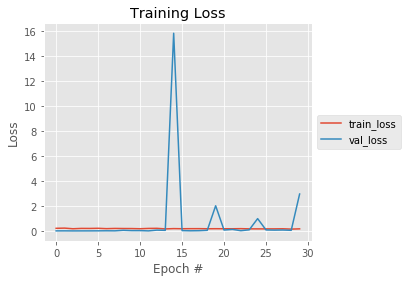

In [8]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, NUM_EPOCHS), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, NUM_EPOCHS), history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

avg_train_loss = sum(history.history["loss"])/NUM_EPOCHS
avg_val_loss = sum(history.history["val_loss"])/NUM_EPOCHS

print("avg_train_loss: " + str(avg_train_loss))
print("avg_val_loss: " + str(avg_val_loss))
print("difference: " + str(abs(avg_train_loss - avg_val_loss)))

In [17]:
from keras.models import load_model

test_generator=test_datagen.flow_from_dataframe(
dataframe=testDF,
directory="/home/jupyter/Project/test/",
x_col="Images",
# y_col="SteeringAngle",
y_col=None,    
batch_size=100,
seed=42,
shuffle=False,
class_mode=None,
target_size=(200, 66))

filepath = "/home/jupyter/Project/VGG/VGG_FT_Chekpoints/VGG_FT_weights.03-0.00.h5"

model.load_weights(filepath)


predictions = model.predict(test_generator)
print('Predictions: ', predictions.shape)

Found 8951 validated image filenames.
Predictions:  (8951, 1)


In [18]:
import pandas as pd

Images = testDF['Images']
preds = predictions
actual = testDF['SteeringAngle']

df_preds = pd.DataFrame(Images)
df_preds['Actual Steering Angle'] = (actual * (pi / 180))
df_preds['Predicted Steering Angle'] = preds
df_preds.rename(columns = {0:'Images'}, inplace = True) 

df_preds['MAE'] = 0

for i in range(len(df_preds)):
  df_preds.iloc[i, -1] = abs(df_preds.iloc[i, 1] - df_preds.iloc[i, 2])

mae_sum = 0
for i in range(len(df_preds)):
    mae_sum += df_preds.iloc[i, -1]
    
print("mae_sum: " + str(mae_sum))    
MAE = mae_sum / len(df_preds)
print("len(df_preds): " + str(len(df_preds)))
print("MAE: " + str(MAE))

mae_sum: 1922.0365112986601
len(df_preds): 8951
MAE: 0.21472869079417498
